In [1]:
from math import sin, cos, log, ceil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
# Euler's method function:
def euler_step(u, f, dt):
    """Returns the solution at the next time-step using Euler's method.
    
    Parameters
    ----------
    u : array of float
        solution at the previous time-step.
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
    
    Returns
    -------
    u_n_plus_1 : array of float
        approximate solution at the next time step."""
    return u + dt * f(u)

# system equation function
def f(u):
    """Returns the right-hand side of the phugoid system of equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        
    Returns
    -------
    dudt : array of float
        array containing the RHS given u.
    """
    
    v = u[0]
    theta = u[1]
    x = u[2]
    y = u[3]
    #print(v,theta,x,y)
    return np.array([-g*sin(theta) - C_D/C_L*g/v_t**2*v**2,
                    -g*cos(theta)/v + g/v_t**2*v,
                    v*cos(theta),
                    v*sin(theta)])

In [43]:
# model parameters:
g = 9.81   # acceleration due to gravity in m/s^2
v_t = 30.0 # trim velocity in m/s
C_D = 1/40 # drag coefficient
C_L = 1    # for convenience

### initial conditions ###
v0 = v_t    # start at trim velocity (or add a delta)
theta0 = 0 # initial angle of trajectory
x0 = 0     # horizontal position is arbitrary
y0 = 1000  # initial altitude

In [44]:
T = 100   # final time
dt = 0.1    # time increment
N = int(T/dt) + 1
t = np.linspace(0,T,N)  # time discretization

# initialize the array containing the solution for each time-step
u = np.empty((N, 4))
u[0] = np.array([v0, theta0, x0, y0]) # fill 1st element with intial values

# time loop - Euler method
for n in range(N-1):
    
    u[n+1] = euler_step(u[n], f, dt)

In [45]:
# get glider's position as function of time
x = u[:,2]
y = u[:,3]

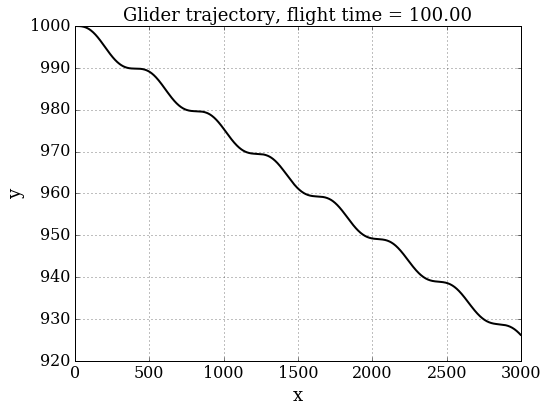

In [47]:
# visualize the path
plt.figure(figsize=(8,6))
plt.grid(True)
plt.xlabel(r'x', fontsize=18)
plt.ylabel(r'y', fontsize=18)
plt.title('Glider trajectory, flight time = %.2f' % T, fontsize=18)
#plt.xlim([-100,50])
#plt.ylim([-50,150])
plt.plot(x,y, 'k-', lw=2)


In [7]:
# convergence:
dt_values = np.array([0.1, 0.05, 0.01, 0.005, 0.001])
u_values = np.empty_like(dt_values, dtype=np.ndarray) #multidimensional array

for i, dt in enumerate(dt_values):
    N = int(T/dt)+1 # number of time steps
    t = np.linspace(0.0, T, N) # time discretization
    
    # initialize array containing the solution for each time-step
    u = np.empty((N,4))
    u[0] = np.array([v0, theta0, x0, y0])
    
    # time loop
    for n in range(N-1):
        u[n+1] = euler_step(u[n], f, dt)
        
    # store the value of u related to each grid
    u_values[i] = u

In [8]:
# differencing function:
def get_diffgrid(u_current, u_fine, dt):
    """Returns the difference between one grid and the fine one using L-1 norm.
    
    Parameters
    ----------
    u_current : array of float
        solution on the current grid.
    u_finest : array of float
        solution on the fine grid.
    dt : float
        time-increment on the current grid.
    
    Returns
    -------
    diffgrid : float
        difference computed in the L-1 norm.
    """
    # Get length of both current and fine u arrays
    N_current = len(u_current[:,0])
    N_fine = len(u_fine[:,0])
    
    # Ratio of number of points so that we can compare the smaller array to the large one
    grid_size_ratio = ceil(N_fine/N_current)
    
    # Get difference between the current and fine arrays x values usint the L1 norm. Can also do for y values.
    diffgrid = dt*np.sum(np.abs(u_current[:,2]-u_fine[::grid_size_ratio,2]))
    
    return diffgrid

In [9]:
# compute differences:
diffgrid = np.empty_like(dt_values)

for i, dt in enumerate(dt_values):
    print('dt = {}'.format(dt))
    
    # Call the get_diffgrid function for each value of dt and the complimentary u array
    diffgrid[i] = get_diffgrid(u_values[i], u_values[-1], dt)

dt = 0.1
dt = 0.05
dt = 0.01
dt = 0.005
dt = 0.001


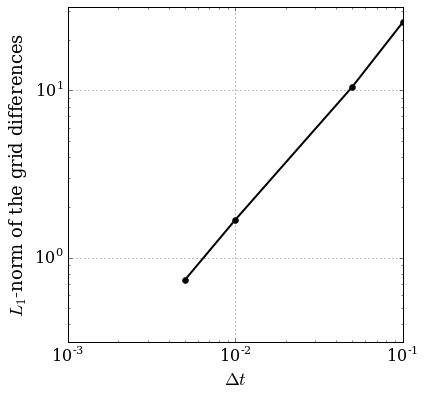

In [10]:
# plot the differences

plt.figure(figsize=(6,6))
plt.grid(True)
plt.xlabel('$\Delta t$', fontsize=18)
plt.ylabel('$L_1$-norm of the grid differences', fontsize=18)
plt.axis('equal')
plt.loglog(dt_values[:-1], diffgrid[:-1], color='k', ls='-', lw=2, marker='o')

In [11]:
# order of convergence
r = 2
h = 0.001

dt_values2 = np.array([h, r*h, r**2*h])
u_values2 = np.empty_like(dt_values2, dtype=np.ndarray)
diffgrid2=np.empty(2)

for i, dt in enumerate(dt_values2):
    
    N = int(T/dt) + 1 # number of time steps
    
    t = np.linspace(0.0, T, N) # time discretization
    
    # initialize arrays
    u = np.empty((N,4))
    u[0] = np.array([v0, theta0, x0, y0])
    
    # time loop
    for n in range(N-1):
        u[n+1] = euler_step(u[n], f, dt)
        
    u_values2[i] = u
    
# calculate f2 - f1
diffgrid2[0] = get_diffgrid(u_values2[1], u_values2[0], dt_values2[1])

# calculate f3 - f2
diffgrid2[1] = get_diffgrid(u_values2[2], u_values2[1], dt_values2[2])

# ccalculate the order of convergence
p = (log(diffgrid2[1]) - log(diffgrid2[0]))/log(r)

print('The order of convergence is p = {:.3f}'.format(p));

The order of convergence is p = 1.014


### Paper airplane challenge

Find initial velocity and and launch angle to maximize flight distance, x.

First I set the model parameters and initial conditions. I create arrays for the initial velocity and angle.

I have found several v0, theta0 combinations that lead to unstable flight behavior. So far: v0 = 1, theta0 = pi/4; v0 = 8, theta0 = pi/6; and v0 = 9, theta0 = pi/12 and theta0 = pi/30. I am unsure as to why this behavior is happening.

In [3]:
# model parameters:
g = 9.81   # acceleration due to gravity in m/s^2
v_t = 5.0  # trim velocity in m/s
C_D = 1.0  # drag coefficient --- or D/L if C_L=1
C_L = 5.0  # to make L/D=5.0

### initial conditions ###
v0 = np.arange(1.,10.)                    # Array of initial velocities 
theta0 = np.arange(0., np.pi/4, np.pi/12) # Array of initial angles of attack
x0 = 0     # horizontal position is arbitrary
y0 = 100  # initial altitude

T = 125   # final time
dt = 0.01    # time increment
N = int(T/dt) + 1
t = np.linspace(0,T,N)  # time discretization

Then we construct some nested loops to interate each initial velocity and angle, and put all solutions arrays, u, into a large, multidimensional array, u_values3. 

Spatial coordinates for each solution are put into xy_values3.

In [4]:
# initialize the array containing the solution for each v0 and theta
# multidimensional array containing the solutions u for each v0/theta0 combo
u_values3 = np.ndarray(shape=(len(v0), len(theta0), N, 4))
xy_values3 = np.ndarray(shape=(len(v0), len(theta0), N, 2)) # this one is just for the x and y values

# do all the loops for v and theta
for i, v in enumerate(v0):
    for k, theta in enumerate(theta0):
        u = np.empty((N, 4))
        u[0] = np.array([v, theta, x0, y0]) # fill 1st element with intial values
        # time loop - Euler method
        for n in range(N-1):
            u[n+1] = euler_step(u[n], f, dt)
            """ 
            this if statement used to stop the calculation once the plane hit the ground (y = 0), but the ndarray, xy_values 
            was still filled with garbage including nan and other weird numbers that were messing up the plot and max x value.
            I would like to have it break out when y drops below zero and then truncate (cut) the rest of the array off but I
            don't know how.
            """
            #if u[n+1,3] <= 0:
             #   break
        u_values3[i,k] = u
        xy_values3[i,k] = u[:,2:]

This finds the minimum positive y value (before plane hits ground) and the index, then puts the corresponding x values from each v0/theta0 pair, into an array. 

Then gets the maximum x value from this subset and the corresponding y value and index from xy_values3. 

Then it puts all the spatial coordinates (before the plane hits the ground) into an array for plotting flight path.

In [5]:
# create array of x/ymin pairs
x_max = np.ndarray(shape=(len(v0), len(theta0), 3))
for i in np.arange(len(v0)):
    for k in np.arange(len(theta0)):
        miny = min(h for h in xy_values3[i,k,:,1] if h > 0)
        minyind = np.where(xy_values3==miny)
        x = float(xy_values3[minyind[0],minyind[1],minyind[2],0])
        # this is the x value corresponding the the minimum positive y value
        x_max[i,k,0] = x
        # this is the minimum positive y value
        x_max[i,k,1] = miny
        # this is the row number of the minimum positive y value so that the flight path to ground may be plotted
        x_max[i,k,2] = minyind[2] 
        
# get index for maximum x value in x_max
x_max_ind = np.where(x_max == np.amax(x_max[:,:,0]))

# create array of x-(positive)y coordinates (flight path) for the v0, theta0 values that maximized flight distance, x.
xmaxy_flight_path = np.zeros([int(x_max[x_max_ind[0],x_max_ind[1],2]),2])
xmaxy_flight_path[:,0] = xy_values3[x_max_ind[0],x_max_ind[1],0:int(x_max[x_max_ind[0],x_max_ind[1],2]),0]
xmaxy_flight_path[:,1] = xy_values3[x_max_ind[0],x_max_ind[1],0:int(x_max[x_max_ind[0],x_max_ind[1],2]),1]

# calculate total flight time
flight_time = x_max[x_max_ind[0],x_max_ind[1],2]*dt

Plots the flight path and prints out resulting maximum distance and corresponding initial conditions

Longest flight distance = 507.63 [m]
for v0 = 9.00 [m/s]
theta0 = 0.00 [degrees]


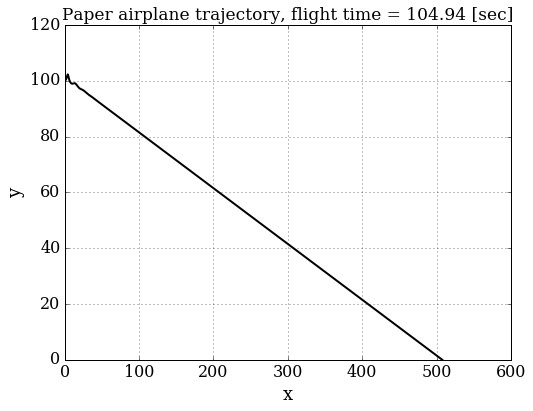

In [11]:
# visualize the path
plt.figure(figsize=(8,6))
plt.grid(True)
plt.xlabel(r'x', fontsize=18)
plt.ylabel(r'y', fontsize=18)
plt.title('Paper airplane trajectory, flight time = %.2f [sec]' % flight_time, fontsize=17)
plt.plot(xmaxy_flight_path[:,0],xmaxy_flight_path[:,1], 'k-', lw=2)
print('Longest flight distance = %0.2f [m]\nfor v0 = %0.2f [m/s]\ntheta0 = %0.2f [degrees]' % (xmaxy_flight_path[-1,0], v0[x_max_ind[0]], theta0[x_max_ind[1]]))

Same as above but puts an inset of the beginning of the flight path in the plot.

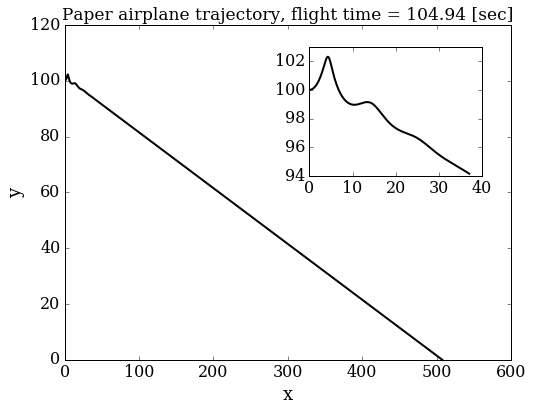

Longest flight distance = 507.63 [m]
for v0 = 9.00 [m/s]
theta0 = 0.00 [degrees]


In [48]:
fig2 = plt.figure(figsize=(8,6))
ax1 = fig2.add_subplot(111)
ax1.plot(xmaxy_flight_path[:,0],xmaxy_flight_path[:,1], 'k-', lw=2)
plt.xlabel(r'x', fontsize=18)
plt.ylabel(r'y', fontsize=18)
plt.title('Paper airplane trajectory, flight time = %.2f [sec]' % flight_time, fontsize=17)

ax2 = plt.axes([0.55, 0.55, 0.3, 0.3])
ax2.plot(xmaxy_flight_path[0:800,0],xmaxy_flight_path[0:800,1], 'k-', lw=2)
ax2.set_xticks([0, 10, 20, 30, 40])
ax2.set_yticks([94, 96, 98, 100, 102])

plt.show()

print('Longest flight distance = %0.2f [m]\nfor v0 = %0.2f [m/s]\ntheta0 = %0.2f [degrees]' % (xmaxy_flight_path[-1,0], v0[x_max_ind[0]], theta0[x_max_ind[1]]))